# ENEM2
Prever nota de matemática do ENEM 2016

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, RidgeCV
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib notebook
except:
    pass

In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
target = 'NU_NOTA_MT'
nu_inscricao = 'NU_INSCRICAO'

# Análise exploratória

## Data prep
Vamos analisar os dados nas bases de treinamento e teste

In [3]:
print('Train:',df_train.shape, '\nTest:',df_test.shape)

Train: (13730, 167) 
Test: (4576, 47)


Note que os dados de teste não tem todas as colunas presentes nos dados de treinamento!
#### Sanity check
Todas as colunas no teste estão no treinamento

In [4]:
set(df_test.columns).issubset(set(df_train.columns))

True

In [5]:
cols_features = list(df_test.columns)
df_train = df_train[cols_features + [target]] #Mantém apenas as colunas que usaremos

####  Tipos das variáveis
Vamos olhar quais os tipos das variaveis, pois nem todas são numéricas. Teremos que avaliar se existe alguma informação útil em *cada* variável

In [6]:
cols_numericas = df_train.select_dtypes(include='number').dtypes.index.values
cols_outras = df_train.select_dtypes(exclude='number').dtypes.index.values

In [7]:
print('Número de colunas numéricas:',
      len(cols_numericas),
      '\nNúmero de colunas não numéricas:',
      len(cols_outras)
     )

Número de colunas numéricas: 33 
Número de colunas não numéricas: 15


Vamos começar pelas variáveis não numéricas, pois são menos casos

In [8]:
cols_outras

array(['NU_INSCRICAO', 'SG_UF_RESIDENCIA', 'TP_SEXO', 'CO_PROVA_CN',
       'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'Q001', 'Q002',
       'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'], dtype=object)

In [9]:
df_train[cols_outras].head()

,NU_INSCRICAO,SG_UF_RESIDENCIA,TP_SEXO,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,RS,M,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,D,D,C,A,A,C,H,A
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,CE,F,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,A,A,B,A,A,A,NaN,A
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,CE,F,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,D,D,C,A,A,A,NaN,A
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,RJ,F,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,H,E,E,C,B,C,F,D
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,AM,M,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,E,D,C,A,A,B,F,A


Vamos simplificar o nosso problema por hora<sup>1</sup>:
-  As variáveis começando com CO indicam a versão da prova feita pelo candidato; Vamos **considerar** que as provas são igualmente complexas, então essas variáveis não devem afetar os resultados;
-  Outro **pressuposto** que podemos fazer é que a habilidade do candidato se reflete em todas as disciplinas da mesma maneira, independente do estado de residência, sexo e condição social.

<sup>1</sup> Num próximo passo podemos incluir de alguma forma a influência destes fatores que estamos excluindo na composição da nota, mas não faremos isso agora.

In [10]:
cols_numericas

array(['CO_UF_RESIDENCIA', 'NU_IDADE', 'TP_COR_RACA', 'TP_NACIONALIDADE',
       'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO',
       'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO',
       'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA',
       'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN',
       'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1',
       'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
       'NU_NOTA_REDACAO', 'NU_NOTA_MT'], dtype=object)

Novamente podemos fazer hipóteses simplificadoras e ignorar as informações sobre saúde, nacionalidade, cor/raça, etc. Após essa seleção temos as seguintes colunas restantes:

In [11]:
cols_numericas = ['NU_IDADE','IN_TREINEIRO',
'NU_NOTA_MT','NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO',
'NU_NOTA_COMP1','NU_NOTA_COMP2','NU_NOTA_COMP3','NU_NOTA_COMP4','NU_NOTA_COMP5',
'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC','TP_STATUS_REDACAO']

Vamos entender melhor o que existe dentro destas variáveis

In [12]:
df_train[cols_numericas].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 16 columns):
NU_IDADE             13730 non-null int64
IN_TREINEIRO         13730 non-null int64
NU_NOTA_MT           10133 non-null float64
NU_NOTA_CN           10341 non-null float64
NU_NOTA_CH           10341 non-null float64
NU_NOTA_LC           10133 non-null float64
NU_NOTA_REDACAO      10133 non-null float64
NU_NOTA_COMP1        10133 non-null float64
NU_NOTA_COMP2        10133 non-null float64
NU_NOTA_COMP3        10133 non-null float64
NU_NOTA_COMP4        10133 non-null float64
NU_NOTA_COMP5        10133 non-null float64
TP_PRESENCA_CN       13730 non-null int64
TP_PRESENCA_CH       13730 non-null int64
TP_PRESENCA_LC       13730 non-null int64
TP_STATUS_REDACAO    10133 non-null float64
dtypes: float64(11), int64(5)
memory usage: 1.7 MB


Olhando para o número de entradas missing, notamos que temos o mesmo número nas notas de Matemática, de Letras e Códigos, e de Redação. Isso indica que essas provas devem ter ocorrido no mesmo dia e, portanto, mesmo sem a informação de que o candidato faltou na prova de matemática, temos como inferir que ele faltou!

Isso também significa que não precisaremos usar as colunas de presença/status.

Vamos verificar essa hipótese:

In [13]:
total_missing_MT = sum(df_train['NU_NOTA_MT'].isnull())
total_missing_LC = sum(df_train['NU_NOTA_LC'].isnull())
total_missing_MT_e_LC = sum(df_train['NU_NOTA_MT'].isnull() & df_train['NU_NOTA_LC'].isnull())
print('missing_MT: {}, missing_LC: {}, missing_simultaneamente: {}'.format(total_missing_MT,total_missing_LC,total_missing_MT_e_LC))

missing_MT: 3597, missing_LC: 3597, missing_simultaneamente: 3597


Dessa forma, temos que manter:
-  A coluna de identificao do candidato 'NU_INSCRICAO'
-  A coluna com a nota de matematica 'NU_NOTA_MT'
-  As seguintes colunas **preditivas**:

In [14]:
cols_preditivas = ['NU_IDADE','IN_TREINEIRO',
'NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO',
'NU_NOTA_COMP1','NU_NOTA_COMP2','NU_NOTA_COMP3','NU_NOTA_COMP4','NU_NOTA_COMP5']

df_train = df_train[ [nu_inscricao, target] + cols_preditivas]

df_train.head()

,NU_INSCRICAO,NU_NOTA_MT,NU_IDADE,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5
0,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,399.4,24,0,436.3,495.4,581.2,520.0,120.0,120.0,120.0,80.0,80.0
1,2c3acac4b33ec2b195d77e7c04a2d75727fad723,459.8,17,0,474.5,544.1,599.0,580.0,140.0,120.0,120.0,120.0,80.0
2,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,NaN,21,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,NaN,25,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,NaN,28,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Correlação
Vamos ver agora se as variáveis que restaram são correlacionadas com a resposta que queremos obter, e se não temos variáveis preditivas muito correlacionadas entre si. O primeiro ponto é importante pois sem correlação não há como prever nada; o segundo ponto também é importante pois muitos métodos podem 'se perder' devido a grandes correlações entre as variáveis preditivas.

(A correlação não é a única maneira de aferir a importância de uma variável e nem sempre é a melhor. Porém, let's *Keep It Simple Stupid* (**KISS**))

In [15]:
df_train.corr()

,NU_NOTA_MT,NU_IDADE,IN_TREINEIRO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5
NU_NOTA_MT,1.000000,-0.061485,-0.022287,0.584941,0.529594,0.494695,0.379376,0.299402,0.335638,0.350307,0.342282,0.343337
NU_IDADE,-0.061485,1.000000,-0.295091,-0.056171,-0.001611,-0.024979,-0.116125,-0.102243,-0.114181,-0.104293,-0.110452,-0.086709
IN_TREINEIRO,-0.022287,-0.295091,1.000000,-0.037874,-0.053460,-0.028261,-0.026328,-0.008709,-0.023308,-0.030147,-0.025958,-0.025811
NU_NOTA_CN,0.584941,-0.056171,-0.037874,1.000000,0.609543,0.545667,0.459938,0.357672,0.412894,0.429447,0.407747,0.416349
NU_NOTA_CH,0.529594,-0.001611,-0.053460,0.609543,1.000000,0.692988,0.550582,0.443809,0.488050,0.510452,0.488797,0.494798
NU_NOTA_LC,0.494695,-0.024979,-0.028261,0.545667,0.692988,1.000000,0.512908,0.430603,0.453262,0.475390,0.467356,0.441696
NU_NOTA_REDACAO,0.379376,-0.116125,-0.026328,0.459938,0.550582,0.512908,1.000000,0.862744,0.918278,0.925813,0.914505,0.816248
NU_NOTA_COMP1,0.299402,-0.102243,-0.008709,0.357672,0.443809,0.430603,0.862744,1.000000,0.756664,0.759452,0.824538,0.558587
NU_NOTA_COMP2,0.335638,-0.114181,-0.023308,0.412894,0.488050,0.453262,0.918278,0.756664,1.000000,0.875447,0.808006,0.655915
NU_NOTA_COMP3,0.350307,-0.104293,-0.030147,0.429447,0.510452,0.475390,0.925813,0.759452,0.875447,1.000000,0.827151,0.664350


<IPython.core.display.Javascript object>


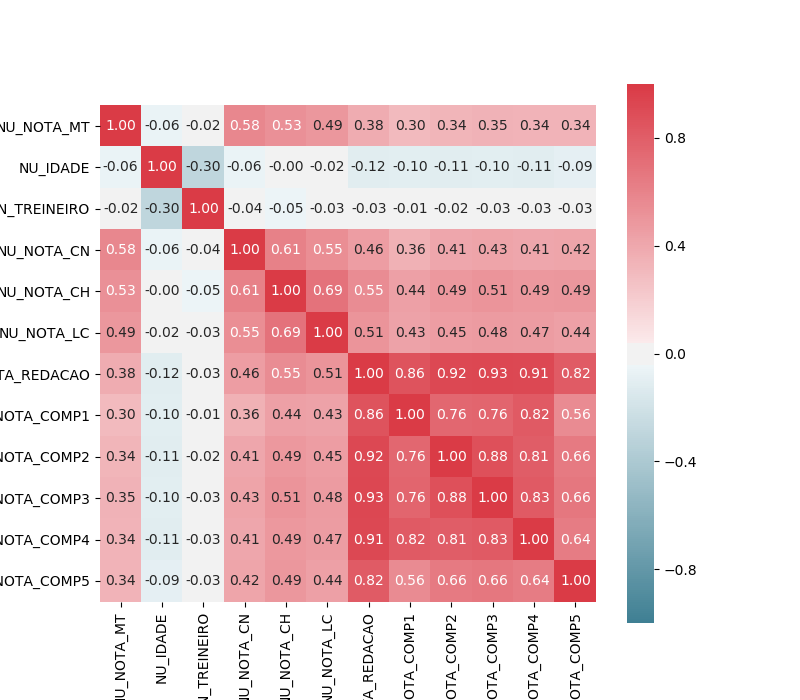

In [16]:
try:
    fig, ax = plt.subplots(figsize=(8, 7))
    corr = df_train.corr()
    sns.heatmap(corr, square=True, ax=ax,vmin=-1,vmax=1,cmap=sns.diverging_palette(220, 10, as_cmap=True),annot=True,fmt='.2f')
except:
    pass

A baixa correlação da idade e da flag de treineiro com a resposta indicam que essas são variáveis desnecessárias no modelo.
Vemos também que todas as notas parciais da redação são extramamente correlacionadas, então vamos manter apenas a nota final. Com isso, vamos tentar prever a nota de matemática com as seguintes variáveis:

In [17]:
cols_preditivas = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_REDACAO']
df_train = df_train[ [nu_inscricao, target] + cols_preditivas]
df_train[cols_preditivas].corrwith(df_train[target])

NU_NOTA_CN         0.584941
NU_NOTA_CH         0.529594
NU_NOTA_LC         0.494695
NU_NOTA_REDACAO    0.379376
dtype: float64

Antes de fazer a regressao, vamos separar as entradas nulas

In [18]:
null_entries = df_train.loc[df_train['NU_NOTA_REDACAO'].isna()]
non_null_entries = df_train.loc[~df_train['NU_NOTA_REDACAO'].isna()]

In [19]:
print(cols_preditivas)
print(sum(non_null_entries[cols_preditivas].isna().values))

['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO']
[36 36  0  0]


Sobraram algumas poucas entradas nulas nas colunas preditivas. Vamos olhar elas com mais cuidado:

In [20]:
non_null_entries[non_null_entries['NU_NOTA_CN'].isna()]

,NU_INSCRICAO,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO
429,a398ec4cdbfc513d15b7b19893373c1a984e3158,0.0,NaN,NaN,0.0,680.0
1000,5b866436facd05bd73720b9da93c134a279145e6,445.4,NaN,NaN,435.4,320.0
1662,7fe975c2d7510fbf6c5ca924fd8402c51b669873,397.6,NaN,NaN,492.1,500.0
1805,0b0033664f0a5a2e45a7173fb9865d68c8f79423,466.8,NaN,NaN,454.2,200.0
1809,de57c76d613f633f2c6941461db7791490625c23,329.0,NaN,NaN,374.4,340.0
1843,78f54ec3c6a37f22bb59505ef43a9a178e911878,381.1,NaN,NaN,373.6,580.0
2760,5fcfa695c6ca08276bbdccf14dcdfcb4206700f0,454.5,NaN,NaN,402.7,500.0
2946,f49f2eecc0c19f784d9f81652eb1488312fea9a8,472.6,NaN,NaN,575.8,440.0
3785,bddd243d16b56dea6609d10a27817928dfe9ee07,461.2,NaN,NaN,496.2,640.0
4202,c749b0b33faed394cc798193b04a5f124acc76bd,409.3,NaN,NaN,536.0,460.0


Uma aproximacao (muuito grosseira) é usar a nota de Letras e Códigos como a nota de matemática

In [21]:
last_null_entries = non_null_entries.loc[non_null_entries['NU_NOTA_CN'].isna()]
really_non_null_entries = non_null_entries.loc[~non_null_entries['NU_NOTA_CN'].isna()]

# Regressão 
Vamos agora usar essas variáveis preditivas para tentar encontrar a nota de matemática dos candidatos.

Como ponto de partida, vamos seguir os passos sugeridos no <a href="http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html">cheat-sheet</a> do scikit-learn

Seguindo o fluxograma, vamos tentar inicialmente a regressão Ridge

In [47]:
res_series = pd.Series()
res_series = res_series.append(null_entries['NU_NOTA_REDACAO'])
res_series = res_series.append(last_null_entries['NU_NOTA_LC'])


X = really_non_null_entries[cols_preditivas].values
y = really_non_null_entries[target].values

regressor = Ridge(normalize=True,alpha=0.0,fit_intercept=False)
regressor.fit(X,y)
y_previsto = regressor.predict(X)

In [48]:
res_series = res_series.append(pd.Series(y_previsto,index=really_non_null_entries.index))
df_train['NU_NOTA_MT_PREVISTA'] = res_series

In [49]:
print(list(zip(cols_preditivas,regressor.coef_)))
print("Intercept:",regressor.intercept_)

[('NU_NOTA_CN', 0.5257690251821104), ('NU_NOTA_CH', 0.2313345156157633), ('NU_NOTA_LC', 0.18999987740165075), ('NU_NOTA_REDACAO', 0.02433176945021699)]
Intercept: 0.0


<IPython.core.display.Javascript object>


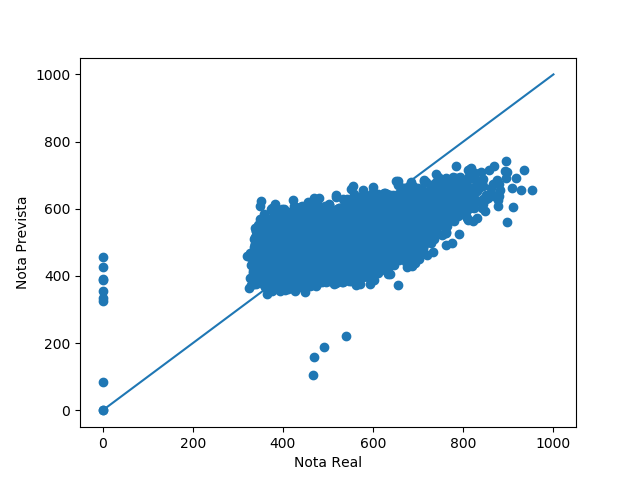

In [52]:
plt.figure()
plt.scatter(df_train['NU_NOTA_MT'],df_train['NU_NOTA_MT_PREVISTA'],alpha=1)
plt.plot([0,1000],[0,1000])
plt.xlabel('Nota Real')
plt.ylabel('Nota Prevista');